# Before we start

# 3 Major ML/DS breakthroughs of the last decade - 2 decades

1. Trainable convolutions
    - Image classification
    - Image segmentation
    - DeepFake
    - Snapchat
    - Face detection
    - ...
---
    
2. Unsupervised approach to learn words vector representation
    - Sentimental analysis
    - Machine translation
    - Text generation (fake news, fake comment/review)
    - Image captioning
    - Text2Voice, Voice2Text
    - Chat bots
    - GPTs

    
---

3. RL Agent based learning
    - AlphaZero
    - MuZero
    - ...

_Upcoming?_

4. Self-driving cars

---

# DeepWalk

## Idea:

Generate node embeddings by constructing a `words` from nodes using a random walk and running a `word2vec` on a resulting corpora.

---

- Paper https://arxiv.org/pdf/1403.6652.pdf
- Python implementation https://github.com/phanein/deepwalk
- C++ https://github.com/xgfs/deepwalk-c

In [1]:
# install Python implementation

!deepwalk --help

usage: deepwalk [-h] [--debug] [--format FORMAT] --input [INPUT] [-l LOG]
                [--matfile-variable-name MATFILE_VARIABLE_NAME]
                [--max-memory-data-size MAX_MEMORY_DATA_SIZE]
                [--number-walks NUMBER_WALKS] --output OUTPUT
                [--representation-size REPRESENTATION_SIZE] [--seed SEED]
                [--undirected UNDIRECTED] [--vertex-freq-degree]
                [--walk-length WALK_LENGTH] [--window-size WINDOW_SIZE]
                [--workers WORKERS]

options:
  -h, --help            show this help message and exit
  --debug               drop a debugger if an exception is raised. (default:
                        False)
  --format FORMAT       File format of input file (default: adjlist)
  --input [INPUT]       Input graph file (default: None)
  -l LOG, --log LOG     log verbosity level (default: INFO)
  --matfile-variable-name MATFILE_VARIABLE_NAME
                        variable name of adjacency matrix inside a .mat file.
     

In [1]:
import networkx as nx

In [2]:
# get karate club graph https://en.wikipedia.org/wiki/Zachary%27s_karate_club

karate = nx.karate_club_graph()

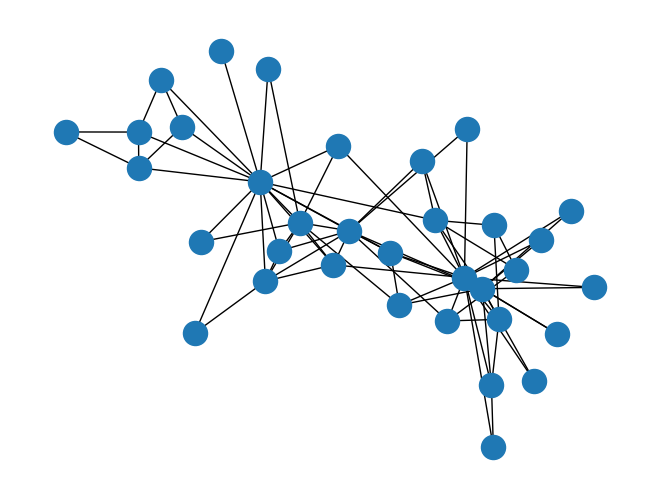

In [25]:
pos = nx.layout.fruchterman_reingold_layout(karate)
nx.draw(karate, pos=pos)

In [3]:
nx.adjacency_matrix(karate).toarray()

array([[0, 4, 5, ..., 2, 0, 0],
       [4, 0, 6, ..., 0, 0, 0],
       [5, 6, 0, ..., 0, 2, 0],
       ...,
       [2, 0, 0, ..., 0, 4, 4],
       [0, 0, 2, ..., 4, 0, 5],
       [0, 0, 0, ..., 4, 5, 0]])

In [4]:
# store as an edgelist

with open('karate.edgelist', 'w') as f:
    for edge in karate.edges:
        f.write(f'{edge[0]} {edge[1]}\n')

In [5]:
# karate_good.embeddings one of the good representations

In [6]:
# run a deepwalk

!deepwalk --seed 41 --representation-size 32 --format edgelist --input karate.edgelist --output karate_2023.embeddings

Number of nodes: 34
Number of walks: 340
Data size (walks*length): 13600
Walking...
Training...
2023-11-01 17:58:38 WARNING word2vec.py: 1545 Both hierarchical softmax and negative sampling are activated. This is probably a mistake. You should set either 'hs=0' or 'negative=0' to disable one of them. 


In [7]:
import numpy as np

In [8]:
# load resulting embedding

with open('karate.embeddings', 'r') as f:
    # first line is a header containing `number of nodes` and `embeddings size`
    n, m = map(int, f.readline().split())
    node_embeddings = np.zeros((n, m))
    # remaining lines are node_id and embedding vector components
    for line in f.readlines():   
        node_id, *emb = line.split(' ')
        node_embeddings[int(node_id)] = list(map(float, emb))

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [10]:
node_embeddings.shape

(34, 32)

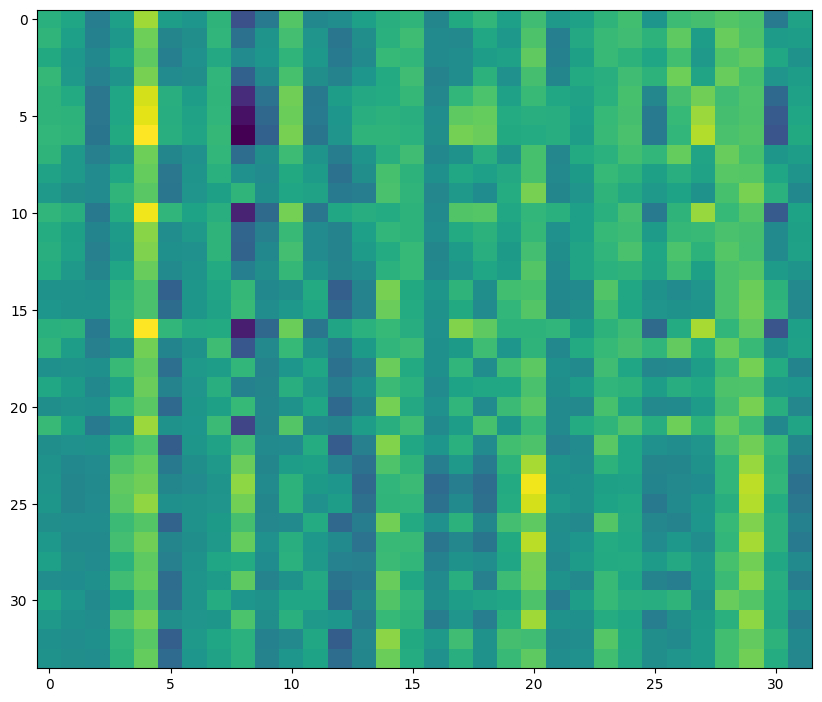

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(node_embeddings, aspect=.8);

In [55]:
node_colors_kmeans = KMeans(4).fit_predict(node_embeddings)

/homes/anvar/miniconda3/envs/valencia/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


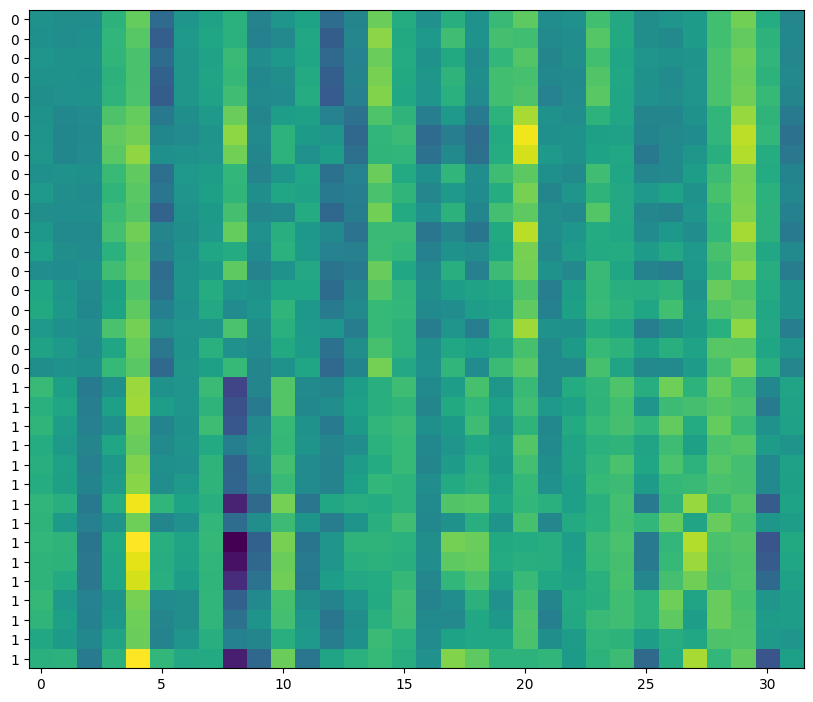

In [27]:
order = np.argsort(node_colors_kmeans)

plt.figure(figsize=(10,10))
plt.imshow(node_embeddings[order, :], aspect=.8);
plt.yticks(ticks = range(34), labels=node_colors_kmeans[order]);

In [28]:
tsne = TSNE(random_state=1, perplexity=5)
node_embeddings_xy = tsne.fit_transform(node_embeddings)

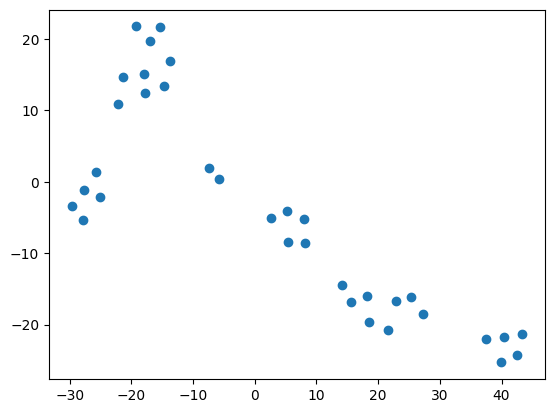

In [29]:
plt.scatter(node_embeddings_xy[:, 0], node_embeddings_xy[:, 1],)# c=node_colors_kmeans);

## Compare to 2 first components of DeepWalk embedding

In [30]:
node_embeddings.shape

(34, 32)

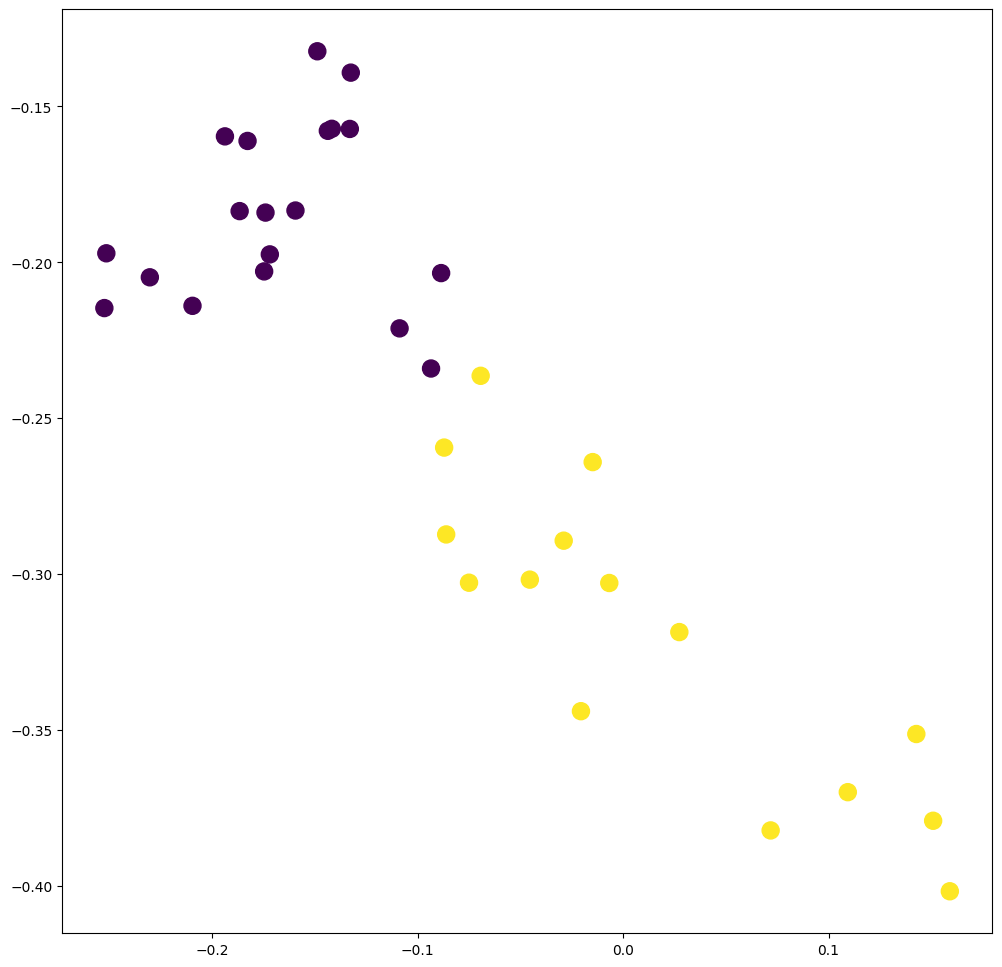

In [31]:
plt.figure(figsize=(12,12))
plt.scatter(node_embeddings[:, 1], node_embeddings[:, 2], s=150, c=node_colors_kmeans);

## Compare to Louvain

In [43]:
from community import community_louvain, best_partition, generate_dendrogram

In [49]:
partition_louvain = np.array(list(community_louvain.partition_at_level(generate_dendrogram(karate), level=1).values()))

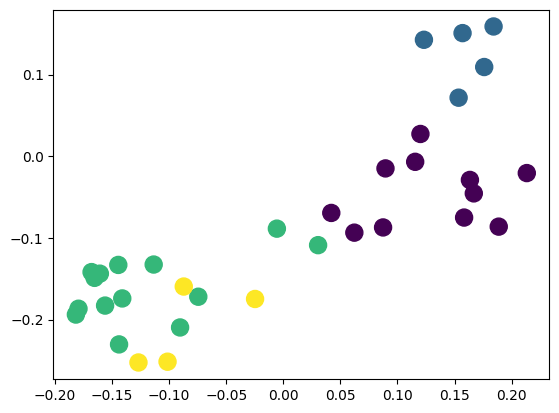

In [57]:
plt.scatter(node_embeddings[:, 0], node_embeddings[:, 1], s=150, c=partition_louvain);

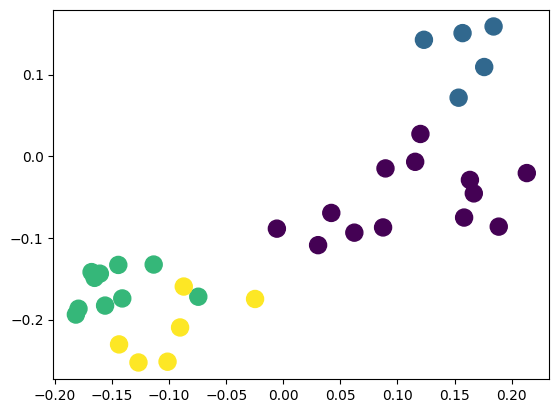

In [58]:
# plt.figure(figsize=(8,8))
plt.scatter(node_embeddings[:, 0], node_embeddings[:, 1], s=150, c=node_colors_kmeans);

In [59]:
from sklearn.metrics import adjusted_rand_score

In [60]:
adjusted_rand_score(node_colors_kmeans, partition_louvain)

0.6704139475063117

## Compare to DeepWalk with embedding size=2

In [61]:
# run a deepwalk

# !deepwalk --representation-size 2 --format edgelist --input karate.edgelist --output karate_2.embeddings

In [62]:
# load resulting embedding

with open('karate_2.embeddings', 'r') as f:
    # first line is a header containing `number of nodes` and `embeddings size`
    n, m = map(int, f.readline().split())
    node_embeddings_2 = np.zeros((n, m))
    # remaining lines are node_id and embedding vector components
    for line in f.readlines():   
        node_id, *emb = line.split(' ')
        node_embeddings_2[int(node_id)] = list(map(float, emb))

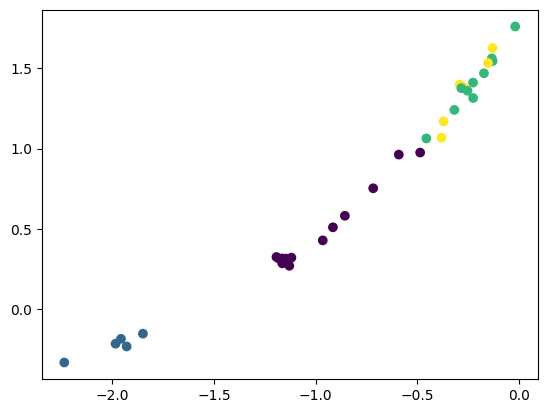

In [63]:
plt.scatter(node_embeddings_2[:, 0], node_embeddings_2[:, 1], c=node_colors_kmeans);

### Conclusion

- To visualize networks' nodes compute DeepWalk embeddings of size 32/64/128 and apply TSNE


## Compare to SpectralClustering

https://arxiv.org/pdf/0711.0189.pdf

In [64]:
# Construct unnormalized Laplacian

A = np.array(nx.adjacency_matrix(karate).todense())
D = np.diag(A.sum(axis=1))
L = D - A
L_normed = np.linalg.inv(D) @ L

In [65]:
# Compute eigenvalues/eigenvectors of L

values, vectors = np.linalg.eigh(L_normed)
# np.allclose(values[1] * vectors[:, 1], L @ vectors[:, 1])

In [66]:
# 34 
# 34 x 34 -> 34, 34x34
# 34 x 4 

In [67]:
spectral_embedding = vectors.T

In [68]:
values

array([-0.8117022 , -0.04257217,  0.19910673,  0.27022948,  0.36521729,
        0.51500273,  0.63096308,  0.69600615,  0.71081409,  0.79847856,
        0.85761643,  0.9473324 ,  0.97692843,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.00816739,  1.11528923,  1.12452509,  1.15188304,  1.2161056 ,
        1.29255479,  1.35841792,  1.53308853,  1.61004432,  1.67088838,
        1.71521754,  1.7247139 ,  1.81461826,  2.55106502])

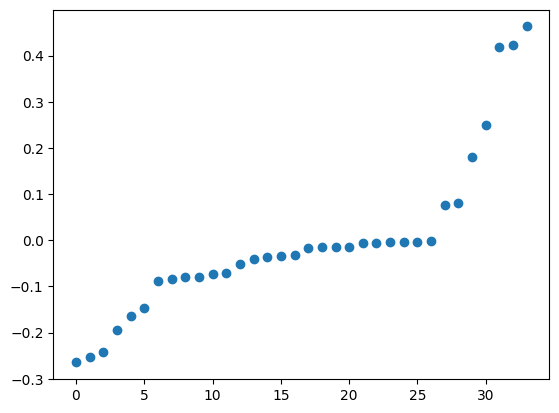

In [69]:
plt.scatter(range(34), sorted(spectral_embedding[1]));

In [70]:
node_colors_spectral = KMeans(4).fit_predict(spectral_embedding[:, :4])

/homes/anvar/miniconda3/envs/valencia/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


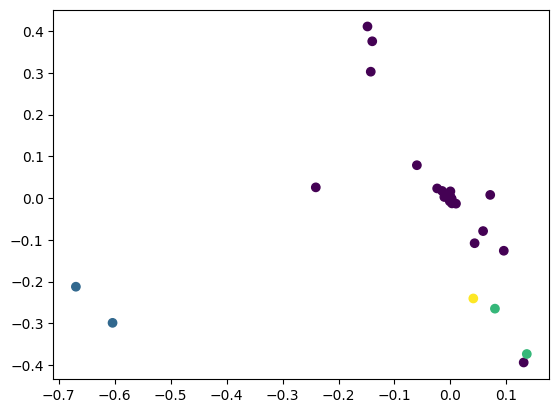

In [71]:
plt.scatter(spectral_embedding[:, 0], spectral_embedding[:, 1], c=node_colors_spectral);

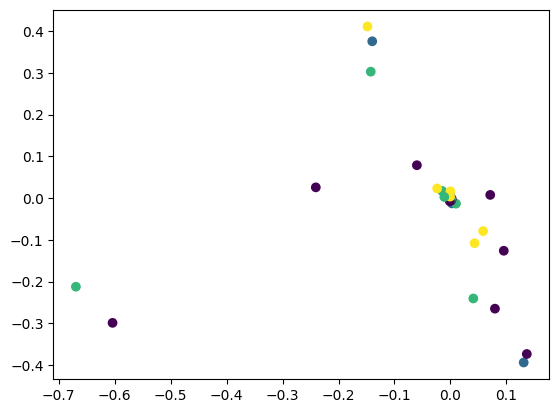

In [72]:
plt.scatter(spectral_embedding[:, 0], spectral_embedding[:, 1], c=node_colors_kmeans);

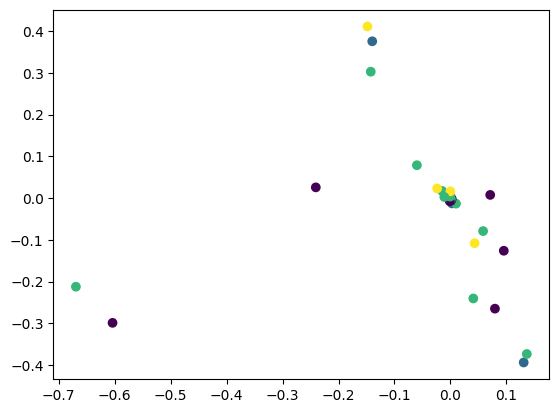

In [73]:
plt.scatter(spectral_embedding[:, 0], spectral_embedding[:, 1], c=partition_louvain);

# Brain network example

In [74]:
adj = np.load('../2020/matrices', allow_pickle=True)
centers = np.load('../2020/node_centers', allow_pickle=True)

for a in adj:
    np.fill_diagonal(a, 0)

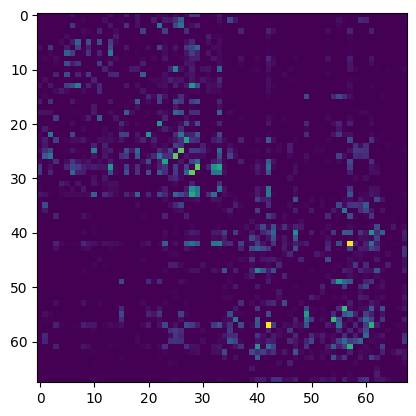

In [75]:
plt.imshow(adj[0])

In [81]:
centers.shape

(807, 68, 3)

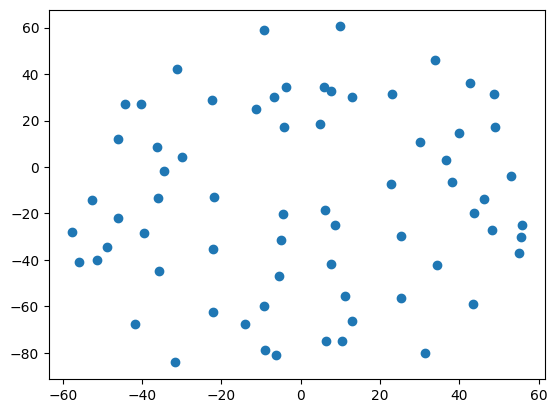

In [85]:

plt.scatter(centers[0, :, 0], centers[0, :, 1])

In [76]:
edge_list = np.vstack(np.nonzero(adj[0])).T

In [77]:
edge_list

array([[ 0,  2],
       [ 0,  4],
       [ 0,  6],
       ...,
       [67, 64],
       [67, 65],
       [67, 66]])

In [78]:
# store as an edgelist

with open('brain.edgelist', 'w') as f:
    for edge in edge_list:
        f.write(f'{edge[0]} {edge[1]}\n')

In [59]:
# run a deepwalk

# !deepwalk --seed 41 --representation-size 32 --format edgelist --input brain.edgelist --output brain.embeddings

In [60]:
# load resulting embedding

with open('brain.embeddings', 'r') as f:
    # first line is a header containing `number of nodes` and `embeddings size`
    n, m = map(int, f.readline().split())
    brain_node_embeddings = np.zeros((n, m))
    # remaining lines are node_id and embedding vector components
    for line in f.readlines():   
        node_id, *emb = line.split(' ')
        brain_node_embeddings[int(node_id)] = list(map(float, emb))

In [61]:
c = [0]*34 + [1]*34

In [62]:
tsne = TSNE(random_state=1, perplexity=10)
node_embeddings_xy = tsne.fit_transform(brain_node_embeddings)

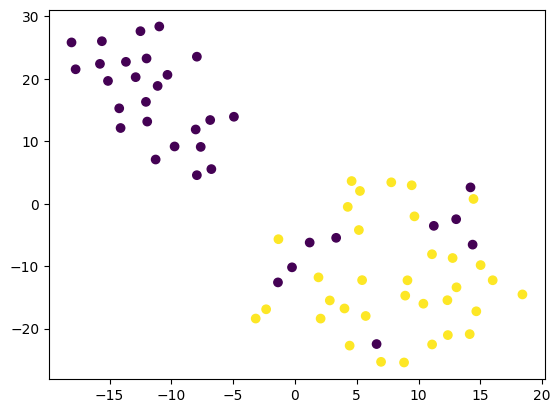

In [63]:
plt.scatter(node_embeddings_xy[:, 0], node_embeddings_xy[:, 1], c=c);

# What is next?

- Node2Vec
- VERSE